# Effects of Weather Events on Flight Delays and Cancellations

## Introduction

This project seeks to form a causal relationship of weather events on the frequency of commercial airline flight delays and cancellations. Flight data was compiled from the Bureau of Transportation Statistics website; weather events were taken from a Kaggle webpag [https://www.kaggle.com/sobhanmoosavi/us-weather-events] based on the paper "Short and Long-term Pattern Discovery Over Large-Scale Geo-Spatiotemporal Data" by Moosavi, et al. All flights in 2016-2019 from the busiest 24 airports in 2018, and the weather events in those cities, were selected.

## Data Fields

The data required extensive preprocessing before analysis; details can be found in the Exploratory Data Analysis (EDA) writeup. Processed data can be found in the `departure_events.csv` file. The origin city and departure date uniquely identify each record. All other fields represent the daily summary of each airport. `departure_events.csv` has the following columns:

* ORIGIN: Three-letter IATA airport code
* DepartureDate: Date of the flights' departures
* ArrivDelay: Arriving flights delayed
* DepartDelay: Departing flights delayed
* Flights: Total departing flights
* WeatherCancelled: Departing flights cancelled due to weather
* WeatherDelayed: Departing flights delayed due to weather
* Cold: Whether the daily temperature dropped below -10.7 F (0 or 1)
* Fog: Presence of fog (0, 1=Light, 2=Heavy)
* Hail: Presence of hail (0 or 1)
* Wind: Wind over 40 mph (0 or 1)
* Rain: Presence of rain (0, 1=Light, 2=Medium, 3=Heavy)
* Sleet: Presence of sleet (0 or 1). Note: The paper did not distinguish between hail and sleet; this had to be done manually. Details are given in the EDA writeup.
* Snow: Presence of snow (0, 1=Light, 2=Medium, 3=Heavy)
* FracCancelled: Fraction of the departing flights cancelled due to weather
* FracDelayed: Fraction of the departing flights delayed due to weather
* Month: Numerical month of the year (1-12)
* Season: (Winter, Spring, Summer, Fall)
* Region: Region of the country based on the location of the airport (West, Midwest, Northeast, South, Florida)

Several of these columns will be removed during this step of the process.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import os
import sys
sys.path.append('D:/Springboard_DataSci/Assignments/Lib')
import TimeTracker

In [2]:
save_plots = True; save_plots = False #whether to save the resulting plots
show_box_plots = True#; show_box_plots = False

pd.options.mode.chained_assignment = None #turns off warnings for data replacements

stopwatch = TimeTracker.TimeTracker()
WORKING_DIR = r'D:\Springboard_DataSci\Assignments\Capstone_2--Airport_weather'
os.chdir(WORKING_DIR + r'\data')

# Load the data
print('Loading flight events')
departure_events = pd.read_csv('departure_events.csv')
arrival_events = pd.read_csv('arrival_events.csv')
inputVars = pd.Series(pd.read_csv('daily_weather.csv').columns[2:-1])

Loading flight events


In [3]:
# Set the fraction of flights per day cancelled and delayed.
FRAC_CANCELLED = 'FracCancelled'
FRAC_DELAYED = 'FracDelayed'
departure_events[FRAC_CANCELLED] = departure_events.WeatherCancelled/departure_events.Flights
arrival_events[FRAC_CANCELLED] = arrival_events.WeatherCancelled/arrival_events.Flights
departure_events[FRAC_DELAYED] = departure_events.WeatherDelayed/departure_events.Flights
arrival_events[FRAC_DELAYED] = arrival_events.WeatherDelayed/arrival_events.Flights
frac_cancelled = departure_events[FRAC_CANCELLED]
frac_delayed = departure_events[FRAC_DELAYED]
departure_events.drop('Unnamed: 0', axis=1, inplace=True)
arrival_events.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
'''Monthly summaries of departure cancellations and delays.'''
def get_monthly_summaries(df):
    monthly_summaries = df[['ORIGIN','DepartureDate',FRAC_CANCELLED,FRAC_DELAYED]]
    monthly_summaries['Month'] = monthly_summaries.DepartureDate.str[5:7].astype(int)
    monthly_summaries = monthly_summaries.groupby(['ORIGIN','Month']).mean().reset_index()
    return monthly_summaries

In [5]:
monthly_summaries = get_monthly_summaries(departure_events)
print('Max fraction of flights affected: %.4f' % monthly_summaries.iloc[:,2:].max().max())
busiest_airports = pd.read_csv('busiest_US_airports2018.csv', index_col='Rank')
busiest_airports.rename({'Airport': 'Code'}, axis=1, inplace=True)
#Naming them by hand to allow for name customization.
busiest_airports['Airport'] =  busiest_airports.Code.map(
    {'ATL':'Atlanta', 'BOS':'Boston', 'CLT':'Charlotte', 'DEN':'Denver', 'DFW':'Dallas/Fort Worth',
     'EWR':'Newark', 'IAH':'Houston Intercontinental', 'JFK':'New York JFK', 'LAS':'Las Vegas',
     'LAX':'Los Angeles', 'MIA':'Miami', 'MCO':'Orlando', 'ORD':"Chicago O'Hare",
     'SEA':'Seattle', 'SFO':'San Francisco', 'PHX':'Phoenix', 'MSP':'Minneapolis–Saint Paul',
     'DTW':'Detroit', 'PHL':'Philadelphia', 'LGA':'New York LaGuardia', 'FLL':'Fort Lauderdale',
     'BWI':'Baltimore/Washington', 'SLC':'Salt Lake City', 'SAN':'San Diego'})
busiest_airports.sort_values(by='Airport', inplace=True)

Max fraction of flights affected: 0.0610


In [6]:
'''Line plots for all the major airports.
Solid red lines = cancellations; broken blue lines = delays.'''
def summaryplots(df, version=''):
    h, w = 6, 4
    months = list('JFMAMJJASOND')
    x = np.arange(1, len(months)+1)
    fig, axs = plt.subplots(nrows=h, ncols=w, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.8, bottom=0.1)
    
    for i in range(h):
        for j in range(w):
            ax = axs[i,j]
            airport_index = df[df.ORIGIN == busiest_airports.iloc[w*i + j].loc['Code']].index.to_numpy()
            ax.plot(x, 100*df.FracDelayed[airport_index], color='b', lw=3, ls='--', label='Delays')
            ax.plot(x, 100*df.FracCancelled[airport_index], color='r', lw=2.5, label='Cancellations')
            ax.set_title(busiest_airports.Airport.iloc[w*i + j], fontsize=12)
            ax.set_xticks(x)
            ax.set_xticklabels(months, fontsize=6)
            ax.set_ylim([0,7])
            ax.tick_params(axis='y', which='major', labelsize=8)
            if i==h-1:
                ax.set_xlabel("Month", fontsize=9)
            if j==0:
                ax.set_ylabel("% of flights", fontsize=9)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=2, borderaxespad=1)
    os.chdir(WORKING_DIR + r'\figures')
    if save_plots:
        plt.savefig('MonthlySummariesByAirport' + str(version) + '.png')
    plt.show()

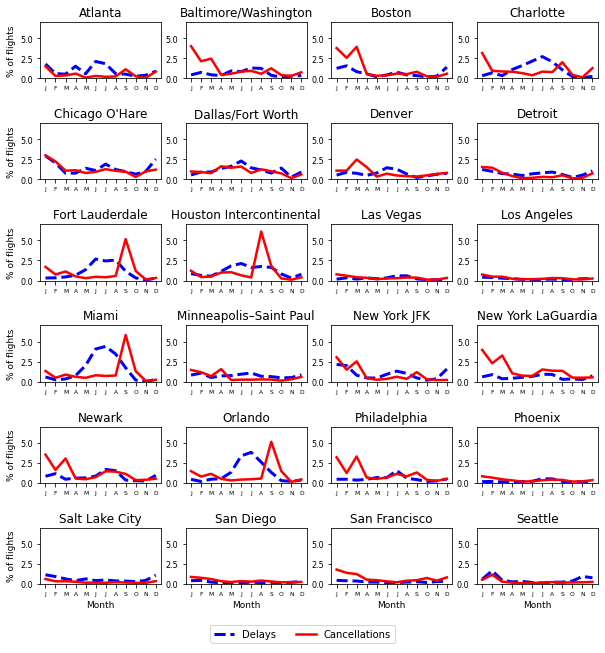

In [7]:
summaryplots(monthly_summaries)

Houston and the Florida airports show spikes in cancellations. Houston's came in
Aug. 2017 from Hurricane Harvey, the Florida airports' came in Sept. 2017 from
Hurricane Irma, and Orlando experienced another round of cancellations from Hurricane
Dorian in 2019. Let's take a closer look at these data.

In [8]:
HARVEY = np.arange(13473, 13480) #no wind codes
IRMA_FLL = np.arange(12056, 12062) #12057 has wind 1, rain 3
IRMA_MCO = np.arange(20637, 20642) #20638 has wind 1, rain 3
IRMA_MIA = np.arange(22066, 22075) #22068 has wind 1, rain 2
DORIAN = np.arange(21328, 21333) #no wind codes
for hurricane in [HARVEY, IRMA_FLL, IRMA_MCO, IRMA_MIA, DORIAN]:
    print(departure_events.iloc[hurricane]\
          .loc[:,['ORIGIN','DepartureDate','Wind','Rain','FracCancelled']])

      ORIGIN DepartureDate  Wind  Rain  FracCancelled
13473    IAH    2017-08-26   0.0   3.0       0.613793
13474    IAH    2017-08-27   0.0   3.0       0.962963
13475    IAH    2017-08-28   0.0   3.0       0.988889
13476    IAH    2017-08-29   0.0   3.0       1.000000
13477    IAH    2017-08-30   0.0   1.0       0.991549
13478    IAH    2017-08-31   0.0   0.0       0.866667
13479    IAH    2017-09-01   0.0   0.0       0.486264
      ORIGIN DepartureDate  Wind  Rain  FracCancelled
12056    FLL    2017-09-08   0.0   1.0       0.304147
12057    FLL    2017-09-09   1.0   3.0       0.985981
12058    FLL    2017-09-10   0.0   0.0       0.986547
12059    FLL    2017-09-11   0.0   0.0       0.986726
12060    FLL    2017-09-12   0.0   0.0       0.717073
12061    FLL    2017-09-13   0.0   1.0       0.239234
      ORIGIN DepartureDate  Wind  Rain  FracCancelled
20637    MCO    2017-09-09   0.0   1.0       0.415625
20638    MCO    2017-09-10   1.0   3.0       0.993884
20639    MCO    2017-09-11  

Harvey in particular dumped an unprecedented amount of rain onto Greater Houston.
Leaving this data in would suggest to the training model later that heavy rain alone
is enough to cause a significant amount of cancellations or even shut down the airport,
as it did then. Note the lack of Wind codes; a hurricane's strong winds are generally
near the eye, but rain can spread out for hundreds of miles.

Dropping all these hurricane data is sensible for the ones where wind=0. For the
other data points, let's see how many data points have Wind>0 and Rain>1.

In [9]:
rain_wind_summary = lambda df, column: df.groupby(['Rain','Wind']).mean()[column].unstack(level='Rain')

rain_wind_cancelled = rain_wind_summary(departure_events, FRAC_CANCELLED)
rain_wind_delayed = rain_wind_summary(departure_events, FRAC_DELAYED)
print('Cancellations vs. rain and wind:\n' + str(rain_wind_cancelled))
print('\nDelays vs. rain and wind:\n' + str(rain_wind_delayed))

Cancellations vs. rain and wind:
Rain       0.0       1.0       2.0       3.0
Wind                                        
0.0   0.005795  0.008494  0.014915  0.024292
1.0   0.045907  0.092150  0.128830  0.118011

Delays vs. rain and wind:
Rain       0.0       1.0       2.0       3.0
Wind                                        
0.0   0.003120  0.008536  0.017819  0.047117
1.0   0.017814  0.028560  0.036527  0.094204


Recall that our correlation between wind and rain is only 0.047. It seems more likely
that high winds and heavy rains independently increase the likelihood of cancellations
and delays. Our best bet is to remove the hurricane events and reanalyze.

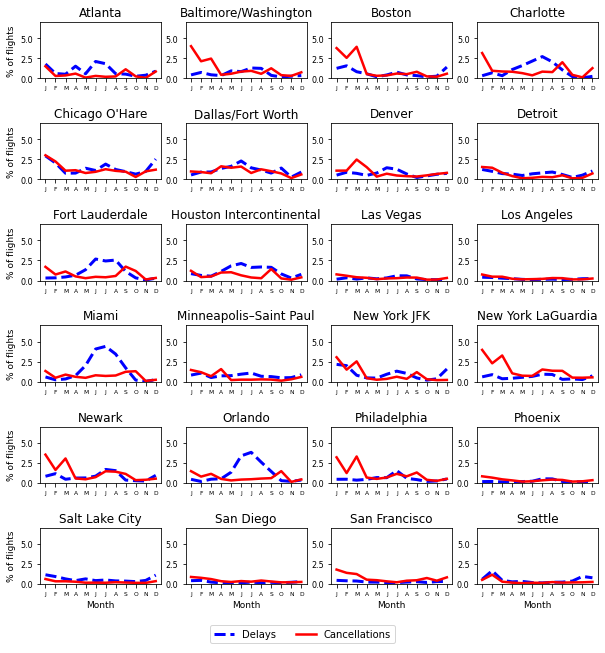

In [10]:
HURRICANE_INDECES = np.r_[HARVEY, IRMA_FLL, IRMA_MCO, IRMA_MIA, DORIAN]
departure_events.drop(HURRICANE_INDECES, axis=0, inplace=True)
frac_cancelled.drop(HURRICANE_INDECES, inplace=True)
frac_delayed.drop(HURRICANE_INDECES, inplace=True)
monthly_summaries1 = get_monthly_summaries(departure_events)
summaryplots(monthly_summaries1, version=1)

Those cancellation spikes are gone.

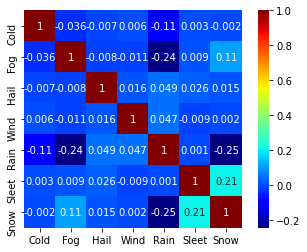

In [11]:
#Weather events correlation matrix
plt.figure()
weather_events_corr = pd.read_csv(
    'D:\Springboard_DataSci\Assignments\Capstone_2--Airport_weather\data\weather_code_corr.csv')
weather_events_corr.set_index(weather_events_corr.columns[0], inplace=True)
weather_events_corr.index.rename('Index', inplace=True)
corr_ax = sns.heatmap(weather_events_corr, square=True, annot=True, cmap=plt.get_cmap('jet'))
corr_ax.set_ylabel('')
if save_plots:
    plt.savefig('CorrMatrixPlot.png')
plt.show()

In [12]:
#Max absolute difference
maxAbsDiff = lambda A, B, axis=None: np.max(np.abs(A-B), axis=axis)

In [13]:
X_dep = departure_events.loc[:, inputVars]
X_arr = arrival_events.loc[:, inputVars]
print('Deviation from X_dep and array of ints:', maxAbsDiff(X_dep, X_dep.astype(int)) )
print('\nDeviation from X_arr and array of ints:', maxAbsDiff(X_arr, X_arr.astype(int)) )
X_dep = X_dep.astype(int)
X_arr = X_arr.astype(int)

Deviation from X_dep and array of ints: Cold     0.0
Fog      0.0
Hail     0.0
Wind     0.0
Rain     0.0
Sleet    0.0
Snow     0.0
dtype: float64

Deviation from X_arr and array of ints: Cold     0.0
Fog      0.0
Hail     0.0
Wind     0.0
Rain     0.0
Sleet    0.0
Snow     0.0
dtype: float64


In [14]:
print("Deviation between X_dep and X_arr's correlation matrices:")
print(maxAbsDiff(X_dep.corr(), X_arr.corr()))

Deviation between X_dep and X_arr's correlation matrices:
Cold     0.009808
Fog      0.000846
Hail     0.000291
Wind     0.009808
Rain     0.002287
Sleet    0.000149
Snow     0.000563
dtype: float64


These deviations are very low, which is to be expected given that X_dep and
X_arr have very similar daily data. We will proceed only with departure events.

In [15]:
Avg = pd.DataFrame(map(list, zip(inputVars.values, np.average(
    X_dep, axis=0, weights=departure_events.Flights))), columns=['Code', 'WtAvg'])
Avg = Avg.set_index('Code')['WtAvg']
print('\nWeighted averages: ' + str(Avg) + '\n')


Weighted averages: Code
Cold     0.005150
Fog      0.172958
Hail     0.001543
Wind     0.005798
Rain     0.500502
Sleet    0.002484
Snow     0.071907
Name: WtAvg, dtype: float64



Now let's do some plots, per code, categorized by code value. To make things
simpler we will not weight these values for now. There are a ton of outliers; we
will do the plots both with and without them.

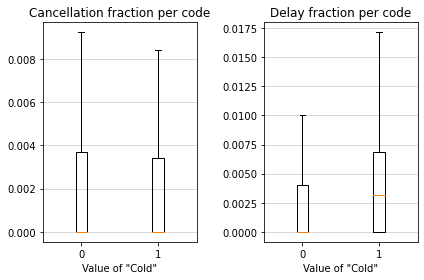

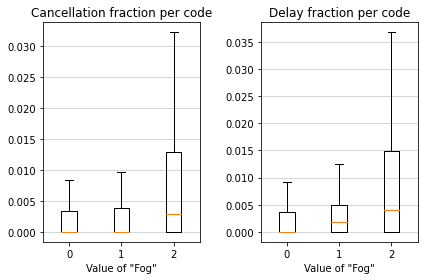

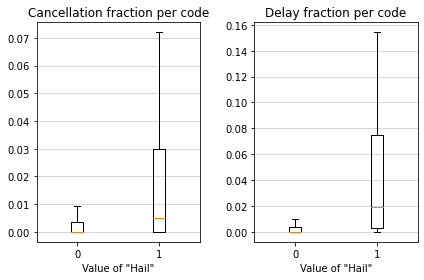

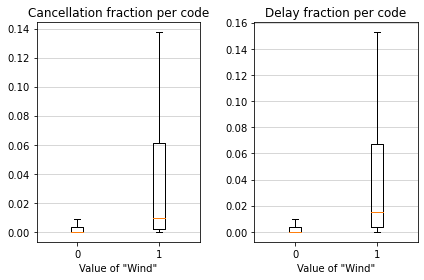

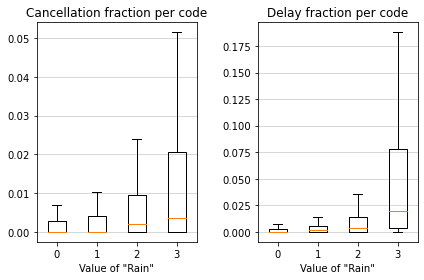

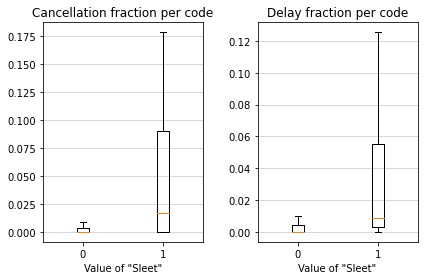

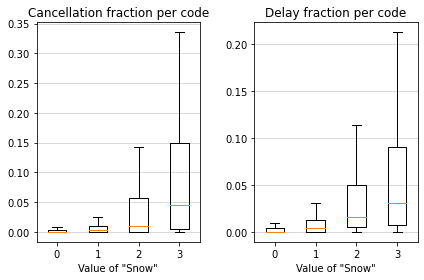

In [16]:
if show_box_plots:
    for showfliers in [False]: #Outliers. Including outliers gives messy plots.
        for weatherCode in inputVars:
            unique_codes = np.sort(X_dep[weatherCode].unique()) #A Series of value counts indexed by code #
            cancelled_per_code = [frac_cancelled[X_dep[weatherCode]==j] for j in unique_codes]
            delayed_per_code = [frac_delayed[X_dep[weatherCode]==j] for j in unique_codes]
        
            fig, axs = plt.subplots(1,2)
            axs[0].boxplot(cancelled_per_code, showfliers=showfliers)
            axs[0].set_title('Cancellation fraction per code')
            axs[1].boxplot(delayed_per_code, showfliers=showfliers)
            axs[1].set_title('Delay fraction per code')
            for j in [0,1]:
                axs[j].set_xticklabels(unique_codes)
                axs[j].set_xlabel('Value of "' + weatherCode + '"')
                axs[j].grid(axis='y',zorder=-2, linewidth=0.5)
            plt.tight_layout()
            if save_plots and not showfliers:
                plt.savefig('BoxPlot' + weatherCode + '.png')
            plt.show()

The medians of some of these features clearly are affected by the feature value;
however, none of them seem to add up to much more than about 0.20, meaning that
we should not expect that these weather events will have an overwhelming affect
on delays and cancellations. Still, there do seem to be trends that emerge.

In [17]:
# Get rid of some variables that are no longer needed.
del(Avg, X_arr, X_dep,arrival_events, corr_ax, frac_cancelled, frac_delayed, weather_events_corr,
    HARVEY, IRMA_FLL, IRMA_MCO, IRMA_MIA, DORIAN, HURRICANE_INDECES, hurricane)

Next, we would like to categorize the results according to region. This should be
a combination of similar geography and regions.
1. Florida gets its own region due to all the weather delays in the summer.
2. Denver is classified as "Midwest" because it resembles these' airports weather
    problems more than the rest of the Western airports.

In [18]:
region_map = {'Northeast':['BWI','PHL','EWR','JFK','LGA','BOS'],
              'West':['SLC','PHX','SAN','LAX','SFO','SEA','LAS'],
              'Midwest':['DTW','ORD','MSP','DEN'],
              'South':['ATL','CLT','IAH','DFW'],
              'Florida':['MCO','MIA','FLL']}

WINTER = 'Winter'; SPRING = 'Spring'; SUMMER = 'Summer'; FALL = 'Fall'
# We could get this down to the exact dates, but let's be consistent with the line charts.
season_map = {WINTER: [1,2,3], #Jan, Feb, Mar
              SPRING: [4,5,6], #Apr, May, Jun
              SUMMER: [7,8,9], #Jul, Aug, Sep
              FALL: [10,11,12]} #Oct, Nov, Dec

In [19]:
'''Maps a dictionary onto a column of a DataFrame.

df: The DataFrame to map onto.
inputCol: Name of the DataFrame's column.
dict_map: The mapping dictionary.'''
def mapDict(df, inputCol, dict_map):
    output = []
    for x in df[inputCol]:
        for key, items in dict_map.items():
            if x in items:
                output.append(key)
                break
        else:
            raise ValueError(x + ' ' + str(items) + ' not listed in your dictionary')
    return output

In [20]:
departure_events['Month'] = departure_events.DepartureDate.str[5:7].astype(int) #month no.
print('Calculating season')
departure_events['Season'] = pd.Series(mapDict(departure_events, 'Month', season_map))
print('Assigning regions')
departure_events['Region'] = mapDict(departure_events, 'ORIGIN', region_map)

airport_groups = departure_events.drop(
    ['ArrivDelay','DepartDelay',FRAC_CANCELLED,FRAC_DELAYED,'Month'], axis=1)\
    .groupby(['ORIGIN','Season']).sum().reset_index()

Calculating season
Assigning regions


In [21]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import os
import sys
sys.path.append('D:/Springboard_DataSci/Assignments/Lib')
import TimeTracker

Before we begin formal training of the data, let's look at each weather code
one at a time and attempt to sift significant from insignificant codes. It is possible
that statistical significance may not kick in until the higher value of some codes.

In [22]:
os.chdir(WORKING_DIR + r'\data')
EFFECTS = [FRAC_CANCELLED, FRAC_DELAYED]
CODES = ['Cold','Fog','Hail','Wind','Rain','Sleet','Snow']
FOGIS2 = 'FogIs2'

In [23]:
'''Linear regression with significance testing.'''
def linreg(X, y, print_stats=True):  
    X2 = sm.add_constant(X)
    estimate = sm.OLS(y, X2).fit()
    if print_stats:
        print(estimate.summary())
    return estimate.pvalues[1:], estimate.rsquared #first p-value is for the constant

In [24]:
'''Extracts just the p-values and R^2's from a multivariate linear regression.

summary_stats: List of lists of the p-value, R^2, and weather code.'''
def pvalue_and_R2(summary_stats, codes=CODES):
    df = pd.DataFrame(summary_stats, index=[_ for _ in codes for i in range(2)],
                      columns=['pValue', 'R^2', 'Effect'])
    return df[df.Effect == EFFECTS[0]].loc[:,:'R^2'],\
        df[df.Effect == EFFECTS[1]].loc[:,:'R^2'] #Cancellations then delays

In [25]:
# Evaluate significance for all codes between values of 0 and 1.
flights_affected = departure_events[EFFECTS]
summary_stats = []
for weather_code in CODES:
    x = departure_events[weather_code]
    indeces = (x <= 1)
    x = x[indeces]
    for effect in EFFECTS:
        y = departure_events[effect][indeces]
        # print('\nLinear regression analysis for', weather_code, 'of', effect+':')
        pvalue, R2 = linreg(x, y, print_stats=False)
        summary_stats.append([pvalue[0], R2, effect])
cancellation_stats, delay_stats = pvalue_and_R2(summary_stats)
print('\nCancellation summary stats:\n' + str(cancellation_stats))
print('\nDelay summary stats:\n' + str(delay_stats))


Cancellation summary stats:
              pValue       R^2
Cold    7.144773e-04  0.000334
Fog     5.483213e-01  0.000011
Hail    1.332955e-11  0.001334
Wind   5.663473e-111  0.014507
Rain    1.796061e-09  0.001197
Sleet  1.206266e-190  0.024982
Snow    1.461477e-80  0.010669

Delay summary stats:
              pValue       R^2
Cold    1.579043e-02  0.000170
Fog     2.026928e-01  0.000050
Hail    1.184639e-19  0.002397
Wind    8.345111e-94  0.012237
Rain   4.308106e-127  0.018852
Sleet   1.015732e-41  0.005326
Snow    7.386913e-39  0.005034


By inspection of the R^2 values, we can see the following:<br>
* Cold: Can be discarded entirely. The R^2 is too small, and there is no Cold>1 code.<br>
* Fog: The change between of 0 and 1 is inconsequential. We might be able to discard it depending
on what happens with the 2's.<br>
* Hail, wind, rain, sleet, and snow all have small R^2 but miniscule p-values, so we will
leave them in. Remember that in the case of rain and snow, we have only compared 0's and 1's
so far. Judging by the box plots, we expect more significant results when the 2's and 3's are
factored in.

Let's see if we can omit fog entirely.

In [26]:
departure_events[FOGIS2] = (departure_events.Fog == 2).astype(int)
summary_stats = []
for effect in EFFECTS:
    pvalue, R2 = linreg(X=departure_events[FOGIS2], y=departure_events[effect], print_stats=False)
    summary_stats.append([pvalue[0], R2, effect])
cancellation_stats, delay_stats = pvalue_and_R2(summary_stats, codes=[FOGIS2])
print('\nCancellation summary stats for ' + FOGIS2 + ':\n' + str(cancellation_stats))
print('\nDelay summary stats for ' + FOGIS2 + ':\n' + str(delay_stats) + '\n')


Cancellation summary stats for FogIs2:
               pValue       R^2
FogIs2  1.111953e-133  0.017503

Delay summary stats for FogIs2:
               pValue       R^2
FogIs2  2.752392e-167  0.021922



Now we have statistical significance. This means that both for cancellations and delays,
there is no significant effect between fog's 0's and 1's, but there is between them and 2's.

Let's put all remaining codes together and do one combined linear regression. We'll get rid of 
Cold, the old Fog code, and some other unneeded columns. FogIs2 remains.

In [27]:
print(departure_events.columns)
departure_events = departure_events[[
    'ORIGIN', 'Region', 'Season', 'Hail', 'Wind', 'Rain', 'Sleet',
    'Snow', FOGIS2, 'FracCancelled', 'FracDelayed']]
for effect in EFFECTS:
    print('\nLinear regression analysis on all remaining variables on', effect+':')
    linreg(X=departure_events.loc[:, 'Hail':FOGIS2], y=departure_events[effect])

Index(['ORIGIN', 'DepartureDate', 'ArrivDelay', 'DepartDelay', 'Flights',
       'WeatherCancelled', 'WeatherDelayed', 'Cold', 'Fog', 'Hail', 'Wind',
       'Rain', 'Sleet', 'Snow', 'FracCancelled', 'FracDelayed', 'Month',
       'Season', 'Region', 'FogIs2'],
      dtype='object')

Linear regression analysis on all remaining variables on FracCancelled:
                            OLS Regression Results                            
Dep. Variable:          FracCancelled   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     931.2
Date:                Sun, 09 Aug 2020   Prob (F-statistic):               0.00
Time:                        10:48:03   Log-Likelihood:                 64585.
No. Observations:               34288   AIC:                        -1.292e+05
Df Residuals:                   34281   BIC:                        -1.291e+05
Df Model:   

The R^2's are not very high, but all p-values except for sleet's effect on delays
are highly significant. This means that we have probably found variables that are
contributing to the delays and cancellations, but the decision to group the flights by day
and not by hour may have created a lot of false negatives.

Let's see if we can get some help from introducing the squares of variables whose
values can exceed 1.

In [28]:
departure_events['RainSquared'] = np.square(departure_events.Rain)
departure_events['SnowSquared'] = np.square(departure_events.Snow)
print(departure_events.columns)
# Reorder the columns to put the fraction cancelled and delayed last.
departure_events = departure_events[[
    'ORIGIN', 'Region', 'Season', 'Hail', 'Wind', 'Rain', 'RainSquared', 'Sleet', 'Snow', 'SnowSquared',
    'FogIs2', 'FracCancelled', 'FracDelayed']]
for effect in EFFECTS:
    print('\nLinear regression analysis with Rain^2 and Snow^2 on', effect+':')
    linreg(X=departure_events.loc[:, 'Hail':FOGIS2], y=departure_events[effect])

Index(['ORIGIN', 'Region', 'Season', 'Hail', 'Wind', 'Rain', 'Sleet', 'Snow',
       'FogIs2', 'FracCancelled', 'FracDelayed', 'RainSquared', 'SnowSquared'],
      dtype='object')

Linear regression analysis with Rain^2 and Snow^2 on FracCancelled:
                            OLS Regression Results                            
Dep. Variable:          FracCancelled   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     786.4
Date:                Sun, 09 Aug 2020   Prob (F-statistic):               0.00
Time:                        10:48:03   Log-Likelihood:                 64885.
No. Observations:               34288   AIC:                        -1.298e+05
Df Residuals:                   34279   BIC:                        -1.297e+05
Df Model:                           8                                         
Covariance Type:            nonrobust   

Slightly better. Note that Snow (linear) is now insignificant on FracCancelled but not on FracDelayed.

Now let's develop a physical map. We would like to illustrate the fraction of delays and cancellations
geographically.